In [ ]:
!pip -q install qiskit
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=9f9ed506a63d262e7353085dfa06684d8b8cd8d5d403523949723bb3df8d36e5
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


Quantum Neural Network (QNN) Setup: Data, Qubits, and Readout
===========================================================

This section prepares all the foundational components required
to train and evaluate a Variational Quantum Neural Network (VQNN)
based on a Farhi-style layered ansatz.

1. Reproducibility
   - Fixes NumPy’s random seed to ensure identical training runs.
   - Random number generator (rng) is created with a stable seed.

2. Problem Size and Qubit Register
   - n  : Number of data qubits (4 qubits ⇒ encoding a 2×2 image).
   - n_total : Total qubits = data qubits + 1 readout qubit.
   - readout : Index of the readout qubit (last qubit).

3. Dataset Construction (All 2×2 Binary Images)
   - Enumerates all 2⁴ = 16 possible 2×2 binary images.
   - Each image is encoded as a vector z ∈ {−1, +1}⁴.
   - Label is assigned using a majority rule:
         label = +1  if number_of(+1 bits) ≥ 2
         label = −1  otherwise

4. Train–Test Split
   - Shuffles the dataset using the RNG.
   - First 12 samples, training set.
   - Remaining 4 samples, test set.
   - Split is deterministic due to the fixed seed.

5. Z Readout Operator
   - Constructs a full 2ⁿ × 2ⁿ matrix corresponding to a Z
     measurement on the final qubit.
   - Achieved using tensor products:
         I ⊗ I ⊗ I ⊗ … ⊗ Z  (Z acts only on readout qubit)
   - Used later to compute expectation ⟨Z_readout⟩ for predictions.





In [ ]:
# reproducibility
np.random.seed(42)
rng = np.random.default_rng(42)

# ---- problem size ----
n = 4                 # data qubits (2x2 images)
n_total = n + 1       # +1 readout qubit
readout = n           # index of readout qubit (last)

# --- data: all 2x2 binary images, label = majority (+1 / -1) ---
all_inputs = []
all_labels = []
for num in range(2**n):
    bits = [(num >> k) & 1 for k in reversed(range(n))]
    z = np.array([1 if b==1 else -1 for b in bits])
    lab = 1 if np.sum(z==1) >= 2 else -1
    all_inputs.append(z); all_labels.append(lab)
all_inputs = np.array(all_inputs); all_labels = np.array(all_labels)

# train/test split (stable)
perm = rng.permutation(len(all_inputs))
train_idx = perm[:12]; test_idx = perm[12:]
X_train, y_train = all_inputs[train_idx], all_labels[train_idx]
X_test, y_test = all_inputs[test_idx], all_labels[test_idx]

# --- Readout operator Z on last qubit (full matrix) ---
def build_Z_readout():
    I = np.eye(2)
    Z = np.array([[1,0],[0,-1]])
    M = I
    for _ in range(n-1):
        M = np.kron(M, I)
    M = np.kron(M, Z)
    return M

Z_readout = build_Z_readout()



Farhi-Style Layered QNN (with Data Re-uploading)
===========================================================

This block defines:
1) unpack_params(params, L)
   - Splits the flat parameter vector into:
       layer_a : (L, n)  single-qubit RY angles
       layer_b : (L, n)  CRX angles (data → readout)
       layer_c : (L,)    RY angles on readout
   - Required for building each circuit layer.

2) build_farhi_layered_circuit
   - Constructs the variational circuit:
       • Optional initial X encoding for z ∈ {−1,+1}
       • Data re-uploading via RY(val * encode_scale)
       • Trainable RY on each data qubit (layer_a)
       • Forward + backward CNOT ladder (entangling block)
       • CRX from each data qubit to readout (layer_b)
       • Final RY on readout (layer_c)
   - Returns a QuantumCircuit on n_total qubits.

3) predict_from_z_list
   - Builds the circuit for each input z
   - Simulates statevector
   - Computes ⟨Z_readout⟩ using the readout operator.





In [ ]:
# Farhi-style layered QNN with data re-uploading
def unpack_params(params, L):
    idx = 0
    layer_a = params[idx: idx + L*n].reshape((L, n)); idx += L*n    # single-qubit rotations on data qubits (trainable)
    layer_b = params[idx: idx + L*n].reshape((L, n)); idx += L*n    # controlled-Rx angles to readout
    layer_c = params[idx: idx + L].reshape((L,)); idx += L          # readout Ry per layer
    return layer_a, layer_b, layer_c

def build_farhi_layered_circuit(params, z=None, L=3, encode_scale=pi/2):
    """
    params: 1D array length = L*(2*n + 1)
    z: input vector of shape (n,) with values in {-1, +1}
    encode_scale: angle multiplier for encoding (z * encode_scale)
    """
    qc = QuantumCircuit(n_total)
    # initial data encoding (could be identity depending on z)
    if z is not None:
        for i, val in enumerate(z):
            if val == 1:
                qc.x(i)   # keep original initial bit encoding as in your code
    # initialize/readout
    qc.x(readout)   # same as before

    layer_a, layer_b, layer_c = unpack_params(params, L)
    for l in range(L):
        # --- data re-uploading: encode input again via ry on each data qubit ---
        if z is not None:
            for i, val in enumerate(z):
                # symmetric encoding: -1 -> -encode_scale, +1 -> +encode_scale
                qc.ry(float(val)*encode_scale, i)

        # trainable single-qubit ry on data qubits (layer_a)
        for i in range(n):
            qc.ry(float(layer_a[l,i]), i)

        # entangling chain (CNOT ladder forward/back to create more entanglement)
        for i in range(n-1):
            qc.cx(i, i+1)
        for i in reversed(range(n-1)):
            qc.cx(i+1, i)

        # controlled Rx from each data qubit to readout (layer_b)
        for i in range(n):
            qc.crx(float(layer_b[l,i]), i, readout)

        # final rotation on readout
        qc.ry(float(layer_c[l]), readout)

    return qc

def predict_from_z_list(params, z_list, L=3, measure='Z'):
    preds = []
    for z in z_list:
        sv = Statevector.from_instruction(build_farhi_layered_circuit(params, z=z, L=L))
        if measure=='Z':
            preds.append(np.real(np.vdot(sv.data, Z_readout @ sv.data)))
        else:
            raise ValueError("Only 'Z' supported")
    return np.array(preds)


Loss Function and Parameter-Shift Gradient (QNN Training)
===========================================================

1) empirical_loss_mse
   - Computes Mean Squared Error between:
         predicted ⟨Z_readout⟩ ∈ [-1, 1]
         target labels ∈ {−1, +1}
   - Used as the training objective for stability and smooth gradients.

2) parameter_shift_grad
   - Implements the parameter-shift rule:
         ∂L/∂θ_k = [L(θ_k + π/2) − L(θ_k − π/2)] / 2
   - Loops over all parameters (dataset is small → efficient).
   - Returns gradient vector matching the shape of 'params'.

These functions provide exact analytic gradients for the variational
quantum circuit and are used by the Adam optimizer during training.



In [ ]:
# Loss functions and gradients (parameter-shift)
def empirical_loss_mse(params, z_list, labels, L=3):
    """
    MSE loss between expectation <Z_readout> (in [-1,1]) and label in {-1,1}
    """
    outs = predict_from_z_list(params, z_list, L=L)
    return np.mean((outs - labels)**2)

def parameter_shift_grad(params, z_list, labels, L=3):
    grads = np.zeros_like(params, dtype=float)
    shift = pi/2
    base = empirical_loss_mse(params, z_list, labels, L=L)
    # naive loop (dataset small) - compute shifted losses per parameter
    for k in range(len(params)):
        thp = params.copy(); thm = params.copy()
        thp[k] += shift; thm[k] -= shift
        Lp = empirical_loss_mse(thp, z_list, labels, L=L)
        Lm = empirical_loss_mse(thm, z_list, labels, L=L)
        grads[k] = (Lp - Lm)/2.0
    return grads


Training Loop (Adam Optimization + Parameter-Shift Gradient)
===========================================================

- Initializes model parameters for L-layer QNN:
      total params = L * (2*n + 1)

- Uses Adam-style optimization:
      m, v   : first and second moment vectors
      lr     : learning rate
      beta1, beta2, eps : Adam hyperparameters

- Full-batch training:
      For each epoch:
          1) Compute gradients via parameter-shift
          2) Apply Adam update rule
          3) Compute train/test MSE loss
          4) Store loss history for plotting

- Prints progress every 10 epochs and at final epoch.

This section performs full training of the variational
quantum neural network using exact analytic gradients.



In [ ]:
# Training
L = 4
param_count = L*(2*n + 1)
params = 0.05 * rng.normal(size=param_count)

# Adam-like state
m = np.zeros_like(params)
v = np.zeros_like(params)
beta1, beta2, eps = 0.9, 0.999, 1e-8
lr = 0.05
epochs = 200
history = {"train": [], "test": []}
batch_size = len(X_train)

for ep in range(epochs):
    # full-batch gradient
    grads = parameter_shift_grad(params, X_train, y_train, L=L)
    # adam update
    m = beta1*m + (1-beta1)*grads
    v = beta2*v + (1-beta2)*(grads**2)
    m_hat = m / (1 - beta1**(ep+1))
    v_hat = v / (1 - beta2**(ep+1))
    params = params - lr * m_hat / (np.sqrt(v_hat) + eps)

    Ltr = empirical_loss_mse(params, X_train, y_train, L=L)
    Lte = empirical_loss_mse(params, X_test, y_test, L=L)
    history["train"].append(Ltr); history["test"].append(Lte)
    if ep % 10 == 0 or ep == epochs-1:
        print(f"Epoch {ep:3d} train_mse={Ltr:.4f} test_mse={Lte:.4f}")

Epoch   0 train_mse=2.6093 test_mse=2.9649
Epoch  10 train_mse=0.8429 test_mse=1.8445
Epoch  20 train_mse=0.4618 test_mse=0.8709
Epoch  30 train_mse=0.3665 test_mse=0.5414
Epoch  40 train_mse=0.2822 test_mse=0.4126
Epoch  50 train_mse=0.2009 test_mse=0.2960
Epoch  60 train_mse=0.1761 test_mse=0.3631
Epoch  70 train_mse=0.1692 test_mse=0.5253
Epoch  80 train_mse=0.1717 test_mse=0.6343
Epoch  90 train_mse=0.1714 test_mse=0.6550
Epoch 100 train_mse=0.1693 test_mse=0.6663
Epoch 110 train_mse=0.1699 test_mse=0.6420
Epoch 120 train_mse=0.1686 test_mse=0.6227
Epoch 130 train_mse=0.1672 test_mse=0.6100
Epoch 140 train_mse=0.1664 test_mse=0.5964
Epoch 150 train_mse=0.1659 test_mse=0.5914
Epoch 160 train_mse=0.1657 test_mse=0.5876
Epoch 170 train_mse=0.1655 test_mse=0.5862
Epoch 180 train_mse=0.1655 test_mse=0.5850
Epoch 190 train_mse=0.1654 test_mse=0.5838
Epoch 199 train_mse=0.1654 test_mse=0.5830



Detailed Notes on the Farhi-Style Layered QNN Circuit
===========================================================

Overview
--------
The circuit is a variational quantum neural network (VQNN) inspired by
Farhi et al.'s QNN architecture. It operates on n data qubits plus one
readout qubit and uses repeated layers of parameterized gates combined
with structured entanglement. The goal is to produce an output state
whose expectation ⟨Z_readout⟩ represents the model prediction.

Input Encoding
--------------
1) Binary-to-quantum mapping:
      z ∈ {−1, +1}ⁿ  →  X gate if z[i] = +1
   This gives a clear classical → quantum embedding directly on the
   computational basis.

2) Readout initialization:
      X(readout)
   This sets the readout qubit in |1⟩ initially, enabling stronger
   interaction when CRX gates target it later.

3) Data re-uploading (per layer):
      RY(z[i] * encode_scale)
   Re-encodes classical information into every layer. This increases
   model expressivity and avoids information “washing out” as depth grows.

Layer Structure (Repeated L Times)
----------------------------------
Each layer contains four components, designed to mix information,
introduce entanglement, and couple the data qubits to the readout.

1) Trainable Local Rotations:
      RY(layer_a[l, i]) on each data qubit
   These are learnable parameters enabling the circuit to transform
   encoded features nonlinearly.

2) Entangling Block (Forward + Backward CNOT Ladder):
      CX(0→1), CX(1→2), …, CX(n−2→n−1)
      CX(n−1→n−2), ..., CX(1→0)
   - Forward ladder creates a chain-like correlation structure.
   - Backward ladder “echoes” the entanglement, making it symmetric
     and allowing richer multi-qubit interactions.
   - This double ladder is a signature of Farhi-style QNNs.

3) Controlled-Rx to Readout:
      CRX(layer_b[l, i]) with control=data_qubit_i, target=readout
   - Each data qubit influences the readout qubit.
   - Acts as the main coupling between input features and output neuron.
   - Non-commuting with Z measurement → enables learning.

4) Readout Rotation:
      RY(layer_c[l]) on the readout qubit
   - Adjusts the readout qubit before measurement.
   - Serves as layer-level bias/activation tuning.

Measurement and Output
----------------------
After all layers:
- The statevector is evaluated with the observable Z_readout.
- Prediction = ⟨ψ| Z_readout |ψ⟩ ∈ [−1, +1]
- Final classification is sign(prediction).

Why This Circuit Works as a QNN
-------------------------------
• Data re-uploading + trainable RY allows nonlinear feature mixing.  
• CNOT ladders generate entanglement across all data qubits.  
• CRX gates enable interaction between data features and readout neuron.  
• Final RY on readout behaves like a learnable “activation” layer.  
• The entire architecture forms a differentiable model trained using
  parameter-shift gradients and Adam optimization.



Original Farhi-style Layered Circuit:


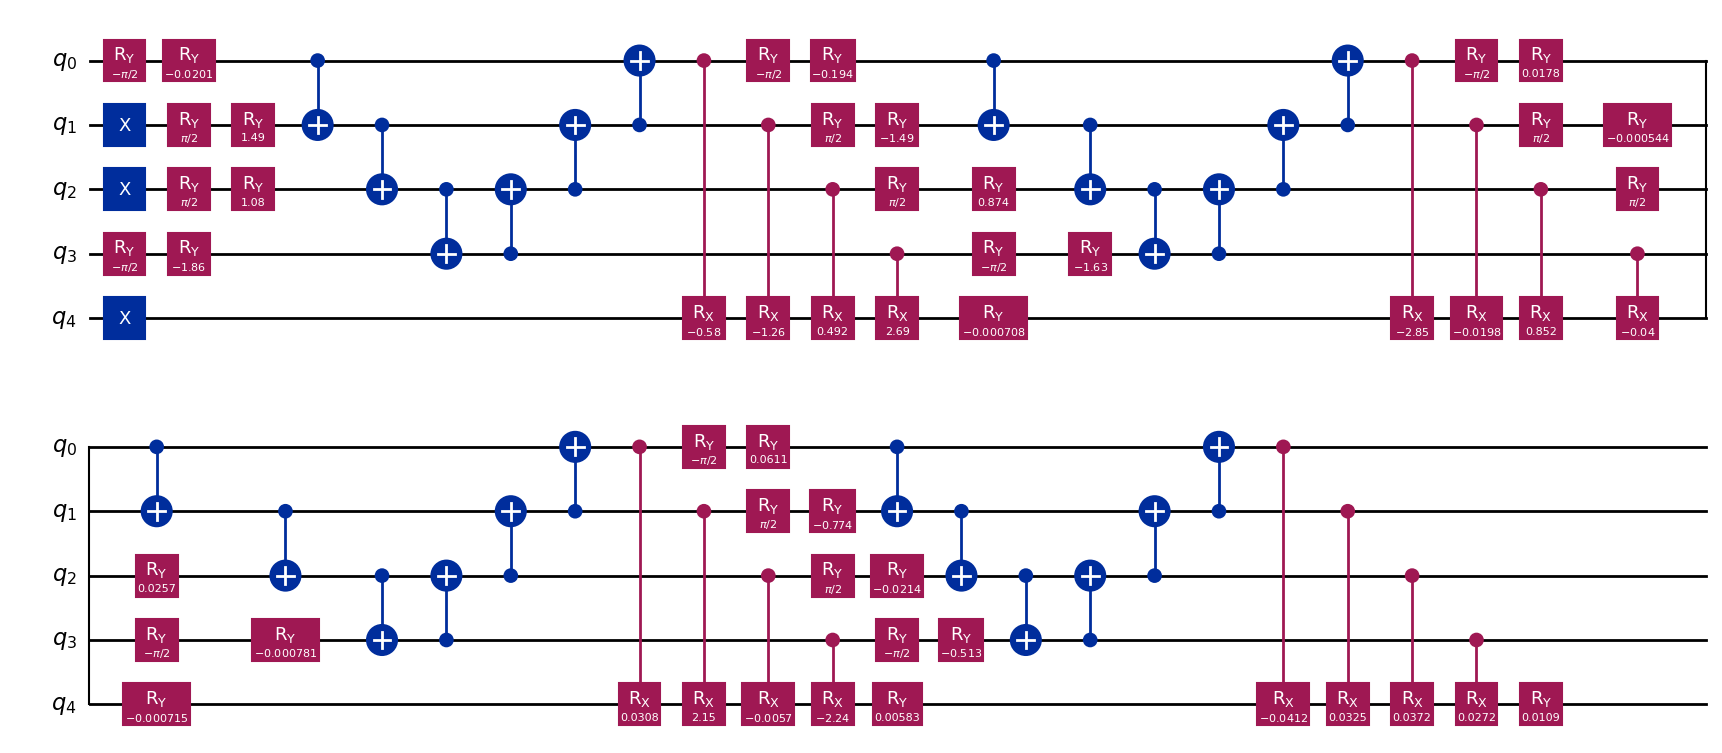

In [ ]:
#CIRCUIT
example_z = X_train[0]

qc_original = build_farhi_layered_circuit(params, z=example_z, L=L)

print("Original Farhi-style Layered Circuit:")
display(qc_original.draw("mpl"))


Visualization and Model Evaluation
===========================================================

1) Training Curve
   - Plots train and test MSE across epochs.
   - Shows convergence behavior of the QNN.
   - Uses full-batch updates since the dataset is small, ensuring stable gradient steps.
   - Stores losses in `history` for later visualization and comparison of learning behavior.


2) Testing Curve
   - Computes ⟨Z_readout⟩ for all test samples.
   - Plots expectation values to visualize separation between
     class +1 and −1.

3) Final Predictions & Accuracy
   - Converts expectation values to class labels using sign rule.
   - Prints input, expectation, true label, and predicted label.
   - Displays final test accuracy.

These plots and metrics summarize the QNN's performance after training.



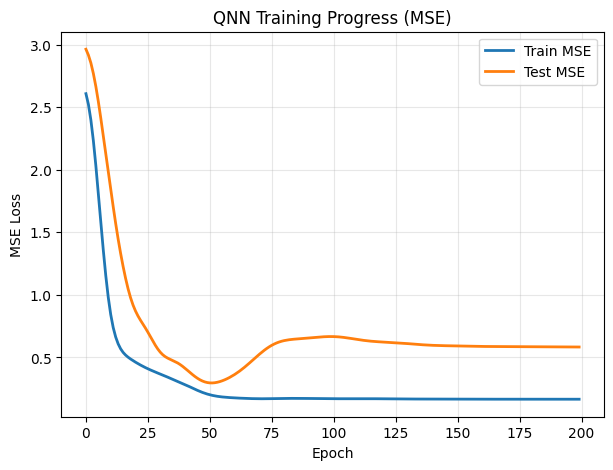

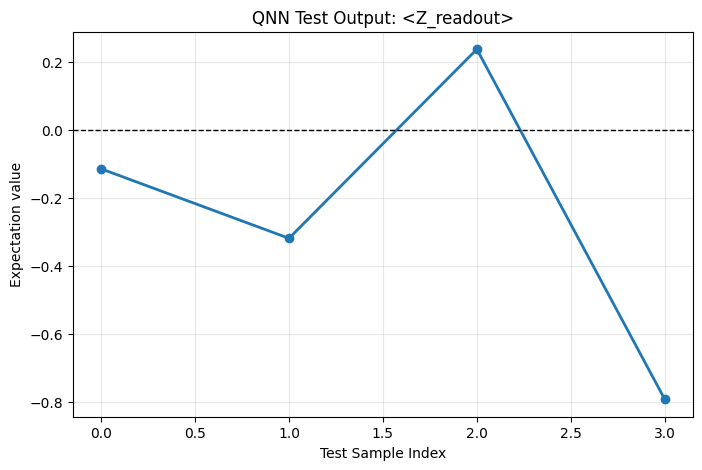

=== Test Predictions ===
#0  z=[1, 1, 1, -1]   exp=-0.115   true=1   pred=-1
#1  z=[-1, -1, -1, 1]   exp=-0.319   true=-1   pred=-1
#2  z=[1, 1, -1, 1]   exp=+0.237   true=1   pred=1
#3  z=[1, -1, -1, -1]   exp=-0.792   true=-1   pred=-1

Test Accuracy: 0.75


In [ ]:
# VISUALIZATION
from qiskit.visualization import circuit_drawer

# 1) Training Curve (MSE)
plt.figure(figsize=(7,5))
plt.plot(history["train"], label="Train MSE", linewidth=2)
plt.plot(history["test"], label="Test MSE", linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.title("QNN Training Progress (MSE)")
plt.grid(True, alpha=0.3); plt.legend()
plt.show()

# 2) Testing Curve (expectation values)
preds = predict_from_z_list(params, X_test, L=L)
plt.figure(figsize=(8,5))
plt.plot(preds, marker="o", linestyle="-", linewidth=2)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("QNN Test Output: <Z_readout>")
plt.xlabel("Test Sample Index"); plt.ylabel("Expectation value")
plt.grid(True, alpha=0.3)
plt.show()

# 3) Final predictions & accuracy
binary_preds = np.where(preds>=0,1,-1)
acc = np.mean(binary_preds==y_test)
print("=== Test Predictions ===")
for i, (z, expval, lab) in enumerate(zip(X_test, preds, y_test)):
    pred = 1 if expval>=0 else -1
    print(f"#{i}  z={z.tolist()}   exp={expval:+.3f}   true={lab}   pred={pred}")
print("\nTest Accuracy:", acc)
